In [1]:
%matplotlib inline

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as cPickle
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, log_loss
import graphviz
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
import cv2

### Helper Functions

In [16]:
def loadData():
    with open('pkl_data/notes_pos.pkl','rb') as f:
        dpos = cPickle.load(f, encoding='latin1')
    with open('pkl_data/notes_neg.pkl','rb') as f:
        dneg = cPickle.load(f, encoding='latin1')
    return (dpos, dneg)

In [6]:
def concatFolds(pos, neg, scores):
    X_pos = np.concatenate([pos[score] for score in scores], axis=0)
    Y_pos = np.ones(X_pos.shape[0])
    X_neg = np.concatenate([neg[score] for score in scores], axis=0)
    Y_neg = np.zeros(X_neg.shape[0])
    X = np.concatenate((X_pos, X_neg), axis=0)
    Y = np.concatenate((Y_pos, Y_neg))
    return (X,Y)

In [7]:
def getTrainTestSplit(pos, neg, test_fold):
    all_folds = pos.keys()
    train_folds = [fold for fold in all_folds if fold != test_fold]
    (X_train, Y_train) = concatFolds(pos, neg, train_folds)
    (X_test, Y_test) = concatFolds(pos, neg, [test_fold])
    return (X_train, Y_train, X_test, Y_test)

In [8]:
def flattenImages(tensor):
    A = tensor.reshape((tensor.shape[0], -1))
    return A

In [9]:
def runCrossValidation(clf, dpos, dneg, flatten = True, pca_dims = None):
    
    labels = np.array([]) # ground truth labels
    preds = np.array([])  # predicted labels 
    probs = np.array([]) # predicted probabilities
    clfs = []
    
    for score in dpos.keys():

        # prep data
        (X_train, Y_train, X_test, Y_test) = getTrainTestSplit(dpos, dneg, score)
        if flatten:
            X_train = flattenImages(X_train)
            X_test = flattenImages(X_test)
        if pca_dims:            
            pca = PCA(n_components = pca_dims)
            pca = pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)

        # fit model
        clf = clf.fit(X_train, Y_train)
        clfs.append(clf)

        # accumulate across folds
        Y_pred = clf.predict(X_test)
        Y_prob = clf.predict_proba(X_test)
        labels = np.concatenate((labels, Y_test))
        preds = np.concatenate((preds, Y_pred))
        probs = np.concatenate((probs, Y_prob[:,1]))

    # cumulative metrics
    acc = accuracy_score(labels, preds)
    logloss = log_loss(labels, probs)  
    
    return (acc, logloss, clfs)

In [10]:
def showImage(X, sz = (4,4)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray', vmin=0, vmax=1)

### PCA Analysis

In [11]:
def calcNumPCADimensions(dpos, dneg, var):
    X_pos = np.concatenate([dpos[score] for score in dpos.keys()], axis=0)
    X_neg = np.concatenate([dneg[score] for score in dpos.keys()], axis=0)
    X_all = np.concatenate((X_pos, X_neg))
    pca = PCA()
    pca = pca.fit(flattenImages(X_all))
    cumvar = pca.explained_variance_ratio_.cumsum()
    nComponents = np.where(cumvar > var)[0][0]
    return (nComponents, pca)

In [12]:
def visualizePCAComponents(comp, rows = 4, cols = 4):
    fig=plt.figure(figsize=(8, 8))
    for i in range(0, cols*rows):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(comp[i].reshape(15,15), cmap='gray')
        plt.title('Comp %d' % i)
    plt.show()

In [17]:
(dpos, dneg) = loadData()
nComponents, pca = calcNumPCADimensions(dpos, dneg, .95)
nComponents

22

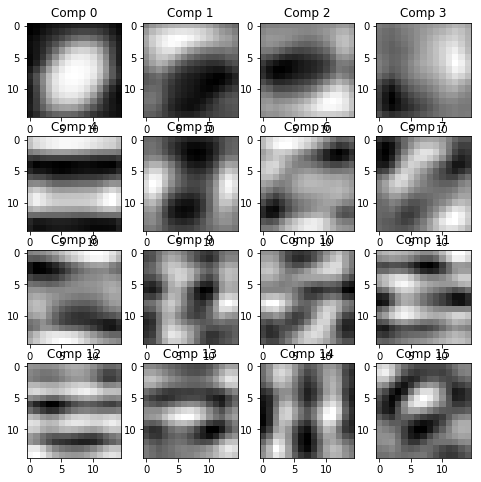

In [18]:
visualizePCAComponents(pca.components_)

### Network

In [21]:
def runCrossValidation_keras(getModel_callback, dpos, dneg, nb_epoch=10, cnn=False):
    
    labels = np.array([]) # ground truth labels
    probs = np.array([]) # predicted probabilities
    models = [] 
    
    for score in sorted(dpos.keys()):

        print('Test fold %s', score)
        (X_train, Y_train, X_test, Y_test) = getTrainTestSplit(dpos, dneg, score)
        if cnn:
            X_train = np.expand_dims(X_train, axis=3)
            X_test = np.expand_dims(X_test, axis=3)
        model = getModel_callback()
        model.fit(X_train, Y_train, nb_epoch=nb_epoch, validation_data=(X_test,Y_test))
        Y_pred = model.predict(X_test)
        labels = np.concatenate((labels, Y_test))
        probs = np.concatenate((probs, np.squeeze(Y_pred)))
        models.append(model)
        
    acc = accuracy_score(labels, np.round(probs))
    logloss = log_loss(labels, probs)  
    
    return (acc, logloss, models)

In [24]:
from keras_spp.spp.SpatialPyramidPooling import SpatialPyramidPooling

In [25]:
from keras_spp.spp.RoiPooling import RoiPooling

In [26]:
batch_size = 2
num_channels = 1
# num_classes = 

In [ ]:
def getModel_convcommon2():
    model = Sequential([
        BatchNormalization(input_shape=(None, None, 1)),
        Conv2D(8, 3, 3, activation='relu', name='conv_one'),
        Conv2D(8, 3, 3, activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(8, 1, 1, activation='relu'),
        Conv2D(8, 1, 1, activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(8, 1, 1, activation='relu'),
        Conv2D(8, 1, 1, activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(225, activation = 'relu'),
        Dense(225, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ])
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [64]:
pooling_regions = [1, 2, 4]
num_rois = 2
num_channels = 1
img_size = 600

In [65]:
in_img = Input(shape=(None, None, num_channels))

In [66]:
in_roi = Input(shape=(num_rois, 4))

out_roi_pool = RoiPooling(pooling_regions, num_rois)([in_img, in_roi])

In [67]:
model = Model([in_img, in_roi], out_roi_pool)

In [68]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2, 4)         0                                            
__________________________________________________________________________________________________
roi_pooling_3 (RoiPooling)      (None, 2, 21)        0           input_4[0][0]                    
                                                                 input_5[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [69]:
X_img = cv2.imread('true_piece.png', cv2.IMREAD_GRAYSCALE)

In [70]:
(x,y) = X_img.shape
X_img = np.expand_dims(X_img, axis=2)
X_img.shape

(842, 595, 1)

In [71]:
X_img = np.expand_dims(X_img, axis=0)
X_img.shape

(1, 842, 595, 1)

In [72]:
X_img.shape

(1, 842, 595, 1)

In [73]:
X_roi = np.array([[0, 0, img_size / 1, img_size / 1],
                  [0, 0, img_size / 2, img_size / 2]])

X_roi = np.reshape(X_roi, (1, num_rois, 4))

In [74]:
Y = model.predict([X_img, X_roi])

InvalidArgumentError: Input to reshape is a tensor with 21750 values, but the requested shape has 22500
	 [[Node: roi_pooling_3/Reshape_19 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](roi_pooling_3/strided_slice_63, roi_pooling_3/Reshape_19/shape)]]
	 [[Node: roi_pooling_3/Reshape_42/_117 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1321_roi_pooling_3/Reshape_42", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'roi_pooling_3/Reshape_19', defined at:
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-ef11b9631d78>", line 3, in <module>
    out_roi_pool = RoiPooling(pooling_regions, num_rois)([in_img, in_roi])
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/data1/dbashir/Project/Summer 2018/keras_spp/spp/RoiPooling.py", line 113, in call
    xm = K.reshape(x_crop, new_shape)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1891, in reshape
    return tf.reshape(x, shape)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3938, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 21750 values, but the requested shape has 22500
	 [[Node: roi_pooling_3/Reshape_19 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](roi_pooling_3/strided_slice_63, roi_pooling_3/Reshape_19/shape)]]
	 [[Node: roi_pooling_3/Reshape_42/_117 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1321_roi_pooling_3/Reshape_42", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
